In [18]:
import bamt.preprocessors
import bamt.networks as Nets
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from itertools import product
from pgmpy.estimators import  K2Score
import numpy as np
import seaborn as sns

from experiments.experiments3.auxiliary.auxiliary import construct_by_quantiles, construct_by_kmeans, construct_by_uniform
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
from bamt_inherited.networks.discrete import DiscreteBNGI
from bamt.nodes.discrete_node import DiscreteNode

import copy

imagespath = './images'

datapath = '../../datasets/files/csv/sangiovese.csv'
structurepath = '../../datasets/files/txt/sangiovese.txt'

SEED = 42

In [3]:
import os

In [5]:
os.getcwd()

'C:\\Users\\Дима\\PycharmProjects\\GIEBN\\experiments\\pgmpy_yodo_exps'

2

In [8]:
data = pd.read_csv(datapath)
data.head()

,Unnamed: 0,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,1,T6a,0.319352,-0.014638,0.690797,1.230259,0.202708,0.190496,0.273637,0.206928,-0.400711,0.151206,0.010867,0.136906,0.262685,0.066611
1,2,T1b,-0.467937,-0.356982,-0.261610,-0.505227,-0.030330,-0.160601,-0.189846,-0.214033,-0.016202,-0.050890,0.036074,0.024552,0.139368,0.249374
2,3,T3b,-0.041105,0.487735,1.354279,0.921248,0.120138,0.032949,0.112869,-0.092149,-0.142178,-0.061097,-0.090681,0.009475,-1.259641,-0.736169
3,4,T3b,-0.045981,0.283028,-0.528793,0.009379,0.018713,0.005606,-0.009545,0.156430,0.194600,-0.016099,0.110614,-0.003483,0.031440,0.266491
4,5,T3a,-0.143411,0.384641,0.202781,0.004403,-0.097482,0.097795,-0.016170,-0.086327,0.024270,-0.241405,-0.101967,-0.043688,-0.336990,-0.383633


In [9]:
data.drop(columns="Unnamed: 0", inplace=True)
variables = data.columns.tolist()

In [4]:
from sklearn.preprocessing import OrdinalEncoder

In [10]:
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import make_pipeline, make_union

In [11]:
icat = [0]
icont = list(range(1, len(variables)))

kmeanspipeline = make_pipeline(make_union(
    make_pipeline(FunctionTransformer(lambda x: x[:, icat]), OrdinalEncoder(categories="auto")),
    make_pipeline(FunctionTransformer(lambda x: x[:, icont]), KBinsDiscretizer(n_bins=3, encode="ordinal", random_state=42, strategy="kmeans"))
),
    FunctionTransformer(lambda x: x.astype("int")))

pd.DataFrame(kmeanspipeline.fit_transform(data.values), columns=data.columns)

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,10,2,1,2,2,2,2,2,2,0,2,1,2,2,1
1,1,0,0,1,0,1,0,0,0,1,1,1,1,1,2
2,5,1,2,2,2,2,1,2,0,0,1,0,1,0,0
3,5,1,2,0,1,1,1,1,2,2,1,2,1,1,2
4,4,0,2,1,1,0,2,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,15,1,0,0,1,1,2,2,0,0,2,2,2,2,1
4996,9,1,2,2,1,1,1,1,2,2,0,0,0,0,1
4997,14,1,1,1,0,1,1,1,1,1,2,0,2,1,0
4998,5,0,0,1,1,1,2,1,1,1,2,1,1,2,1


In [12]:
data_enc = pd.DataFrame(kmeanspipeline.fit_transform(data.values), columns=data.columns)

In [13]:
edges = list()
with open(structurepath) as f:
    edges = [e[:-1].split(" ") for e in f.readlines()]
edges

[['Treatment', 'SproutN'],
 ['Treatment', 'BunchN'],
 ['Treatment', 'SPAD06'],
 ['Treatment', 'Brix'],
 ['SproutN', 'BunchN'],
 ['SproutN', 'GrapeW'],
 ['SproutN', 'WoodW'],
 ['SproutN', 'SPAD06'],
 ['SproutN', 'NDVI06'],
 ['SproutN', 'NDVI08'],
 ['SproutN', 'Acid'],
 ['SproutN', 'pH'],
 ['BunchN', 'GrapeW'],
 ['BunchN', 'WoodW'],
 ['BunchN', 'Acid'],
 ['BunchN', 'Potass'],
 ['BunchN', 'Anthoc'],
 ['BunchN', 'Polyph'],
 ['WoodW', 'GrapeW'],
 ['WoodW', 'pH'],
 ['WoodW', 'Anthoc'],
 ['SPAD06', 'WoodW'],
 ['SPAD06', 'NDVI06'],
 ['SPAD06', 'SPAD08'],
 ['SPAD06', 'Acid'],
 ['SPAD06', 'Potass'],
 ['SPAD06', 'pH'],
 ['NDVI06', 'GrapeW'],
 ['NDVI06', 'SPAD08'],
 ['NDVI06', 'NDVI08'],
 ['NDVI06', 'Acid'],
 ['NDVI06', 'Polyph'],
 ['SPAD08', 'WoodW'],
 ['SPAD08', 'NDVI08'],
 ['NDVI08', 'GrapeW'],
 ['NDVI08', 'WoodW'],
 ['NDVI08', 'Acid'],
 ['NDVI08', 'Anthoc'],
 ['NDVI08', 'Polyph'],
 ['Acid', 'GrapeW'],
 ['Acid', 'pH'],
 ['Potass', 'pH'],
 ['Brix', 'GrapeW'],
 ['Brix', 'Acid'],
 ['Brix', 'pH'],


In [16]:
bmrk_bn = Nets.discrete_bn.DiscreteBN()

In [19]:
#bmrk_bn.add_nodes(descriptor={"types": {e: "disc" for e in variables}})
bmrk_bn.set_structure(edges=edges, info={"types": {e: "disc" for e in variables}}, nodes=[DiscreteNode(name) for name in variables])

? set_structure дублирует узлы и рёбра, хотя всё передано как надо (по крайней мере в текущей версии BAMT)

In [20]:
def remove_set_parameters_outcomes(bn):
    for i, row in bn.get_info().iterrows():
        n_par = len(row["parents"])
        if n_par:
            row["name"].disc_parents = row["name"].disc_parents[:n_par//2]
            row["parents"] = row["parents"][:n_par//2]
            row["parents_types"] = row["parents_types"][:n_par//2]

In [21]:
remove_set_parameters_outcomes(bmrk_bn)
bmrk_bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Treatment,Discrete,disc,[],[]
1,SproutN,Discrete,disc,[Treatment],[disc]
2,BunchN,Discrete,disc,"[Treatment, SproutN]","[disc, disc]"
3,SPAD06,Discrete,disc,"[Treatment, SproutN]","[disc, disc]"
4,NDVI06,Discrete,disc,"[SproutN, SPAD06]","[disc, disc]"
5,SPAD08,Discrete,disc,"[SPAD06, NDVI06]","[disc, disc]"
6,NDVI08,Discrete,disc,"[SproutN, NDVI06, SPAD08]","[disc, disc, disc]"
7,WoodW,Discrete,disc,"[SproutN, BunchN, SPAD06, SPAD08, NDVI08]","[disc, disc, disc, disc, disc]"
8,Anthoc,Discrete,disc,"[BunchN, WoodW, NDVI08]","[disc, disc, disc]"
9,Potass,Discrete,disc,"[BunchN, SPAD06, Anthoc]","[disc, disc, disc]"


In [22]:
c=bmrk_bn.plot("sangi_benchmark.html")

In [14]:
bn = Nets.DiscreteBN()

In [15]:
from pgmpy.estimators import PC, BicScore

In [16]:
bn.add_nodes(bmrk_bn.descriptor)
bn.add_edges(data_enc, scoring_function=("K2", BicScore))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [17]:
bn.edges

[['Treatment', 'Brix'],
 ['SproutN', 'Treatment'],
 ['BunchN', 'SproutN'],
 ['BunchN', 'Treatment'],
 ['BunchN', 'Potass'],
 ['GrapeW', 'BunchN'],
 ['GrapeW', 'WoodW'],
 ['GrapeW', 'Anthoc'],
 ['WoodW', 'SPAD08'],
 ['WoodW', 'NDVI08'],
 ['WoodW', 'SPAD06'],
 ['SPAD06', 'pH'],
 ['SPAD06', 'SproutN'],
 ['SPAD06', 'NDVI06'],
 ['SPAD08', 'SPAD06'],
 ['SPAD08', 'NDVI06'],
 ['NDVI08', 'SPAD08'],
 ['Brix', 'pH'],
 ['Brix', 'Polyph'],
 ['pH', 'Acid'],
 ['pH', 'Potass'],
 ['Anthoc', 'Polyph'],
 ['Anthoc', 'Brix'],
 ['Anthoc', 'WoodW'],
 ['Anthoc', 'NDVI08'],
 ['Polyph', 'Acid']]

In [18]:
from pgmpy.models import BayesianNetwork as BN

In [19]:
bn.fit_parameters(data=data_enc)

In [20]:
n_states_map = {feat: data_enc[feat].unique().shape[0] for feat in variables}
n_states_map

{'Treatment': 16,
 'SproutN': 3,
 'BunchN': 3,
 'GrapeW': 3,
 'WoodW': 3,
 'SPAD06': 3,
 'NDVI06': 3,
 'SPAD08': 3,
 'NDVI08': 3,
 'Acid': 3,
 'Potass': 3,
 'Brix': 3,
 'pH': 3,
 'Anthoc': 3,
 'Polyph': 3}

In [21]:
def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds

In [22]:
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)

In [23]:
import yodo.yodo
import matplotlib.pyplot as plt
import torch

In [24]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
for e in cpds:
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

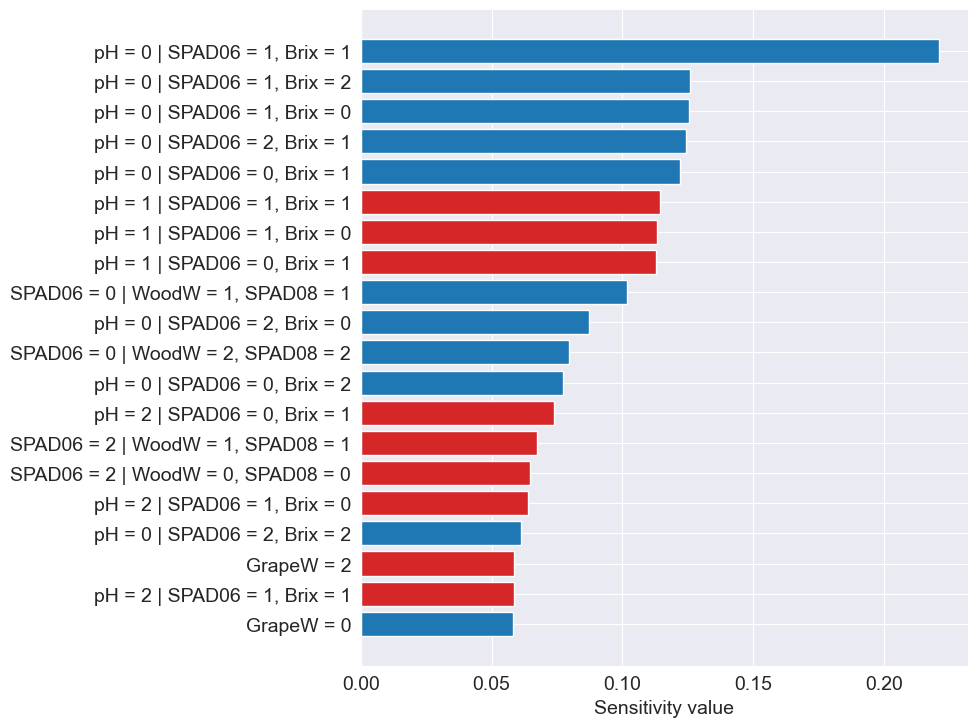

In [25]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'pH': 0}, nbars=20)

<Figure size 640x480 with 0 Axes>

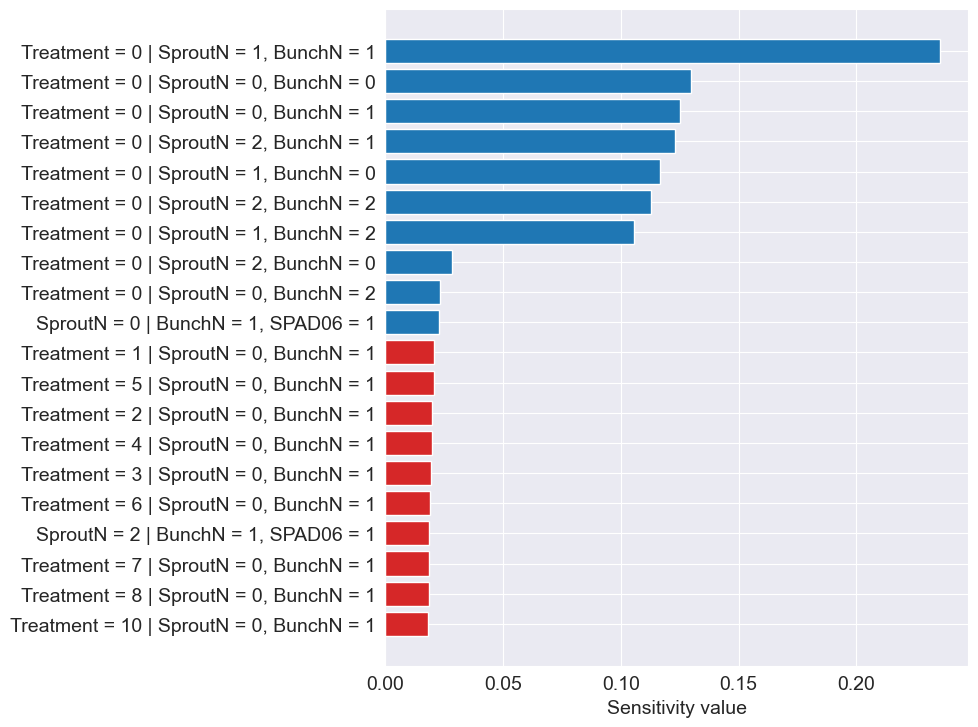

In [26]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'Treatment': 0}, nbars=20)

In [27]:
def where(A, m, dimlen=3):
    for i in range(dimlen):
        if np.any(A[i]==m):
            return i

In [28]:
def argmax_coords(A, ndims, dims_sizes):
    res = list()
    A_copy = np.abs(copy.deepcopy(A))
    maxval = A_copy.max()
    for dim in range(ndims):
        i = where(A_copy, maxval, dims_sizes[dim])
        res.append(i)
        A_copy = A_copy[i]
    return (res, maxval)

In [29]:
def find_top_sensitivity_values(info, vars, first, axis):
    a = info[vars]["derivative"].numpy()
    ndims = len(a.shape)
    a_sliced = np.take(a, indices=[first], axis=axis)
    return vars, argmax_coords(a_sliced, ndims-1, a.shape[1:])

def tuple_where(s, v):
    for i, e in enumerate(s):
        if e == v:
            return i
    return -1

In [30]:
def most_influential_parameter(bn):
    res = dict()
    for feat in variables:
        res[feat] = dict()
        for k in range(3):
            sens = yodo.yodo(bn, probability={feat: k})
            max_val = 0
            for c, values in sens.items():
                if feat in c and values["derivative"].names[0] == feat:
                    feat_index = tuple_where(c, feat)
                    max_deriv_data = find_top_sensitivity_values(sens, c, k, feat_index)
                    if max_deriv_data[1][1] > max_val:
                        max_val = max_deriv_data[1][1]
                        res[feat][k] = max_deriv_data
    return res

In [31]:
res = most_influential_parameter(pgmpy_bn)

In [32]:
sens = yodo.yodo(pgmpy_bn, probability={"Brix": 0})

In [33]:
for k, v in sens.items():
    print(k)

('GrapeW',)
('BunchN', 'GrapeW')
('Anthoc', 'GrapeW')
('Anthoc', 'GrapeW', 'WoodW')
('Anthoc', 'NDVI08', 'WoodW')
('NDVI08', 'SPAD08', 'WoodW')
('SPAD06', 'SPAD08', 'WoodW')
('BunchN', 'SPAD06', 'SproutN')
('NDVI06', 'SPAD06', 'SPAD08')
('BunchN', 'SproutN', 'Treatment')
('BunchN', 'Potass', 'pH')
('Acid', 'Polyph', 'pH')
('Anthoc', 'Brix', 'Treatment')
('Brix', 'SPAD06', 'pH')
('Anthoc', 'Brix', 'Polyph')


In [34]:
res

{'Treatment': {0: (('BunchN', 'SproutN', 'Treatment'),
   ([0, 0], 0.12990839207000912)),
  1: (('BunchN', 'SproutN', 'Treatment'), ([1, 1], 0.23566928571838647)),
  2: (('BunchN', 'SproutN', 'Treatment'), ([2, 2], 0.11288684336508574))},
 'SproutN': {0: (('BunchN', 'SPAD06', 'SproutN'),
   ([0, 1], 0.11926711761717007)),
  1: (('BunchN', 'SPAD06', 'SproutN'), ([1, 1], 0.2307440733388442)),
  2: (('BunchN', 'SPAD06', 'SproutN'), ([2, 1], 0.13358880904398582))},
 'BunchN': {0: (('BunchN', 'GrapeW'), ([0], 0.4692000000000001)),
  1: (('BunchN', 'GrapeW'), ([0], 0.4692000000000001)),
  2: (('BunchN', 'GrapeW'), ([0], 0.4692000000000001))},
 'GrapeW': {0: (('GrapeW',), ([], 1.0000000000000002)),
  1: (('GrapeW',), ([], 1.0000000000000002)),
  2: (('GrapeW',), ([], 1.0))},
 'WoodW': {0: (('Anthoc', 'GrapeW', 'WoodW'), ([0, 2], 0.1232)),
  1: (('Anthoc', 'GrapeW', 'WoodW'), ([1, 1], 0.2424)),
  2: (('Anthoc', 'GrapeW', 'WoodW'), ([2, 0], 0.15339999999999998))},
 'SPAD06': {0: (('SPAD06', 'SP

In [35]:
def extract_yodo_connections(yodo_res):
    grad_edges = list()
    for feat, values in yodo_res.items():
        for k, d in values.items():
            feats, infl_states = d
            i = 0
            for f in feats:
                if f != feat:
                    new_edge = [f+'_'+str(infl_states[0][i]), feat+'_'+str(k)]
                    grad_edges.append(new_edge)
                    i+=1
    return grad_edges

grad_edges = extract_yodo_connections(res)

In [36]:
kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_

[array(['T1a', 'T1b', 'T2a', 'T2b', 'T3a', 'T3b', 'T4a', 'T4b', 'T5a',
        'T5b', 'T6a', 'T6b', 'T7a', 'T7b', 'T8a', 'T8b'], dtype=object)]

In [42]:
treatment_inv_map_src = kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]

gbn = DiscreteBNGI(imagespath, custom_mapper={"Treatment": {k: treatment_inv_map_src[k] for k in range(treatment_inv_map_src.shape[0])}}, max_cat=3)
grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
gbn.set_edges(grad_edges)

In [43]:
gbn.nodes

[Treatment_0,
 Treatment_1,
 Treatment_2,
 Treatment_3,
 Treatment_4,
 Treatment_5,
 Treatment_6,
 Treatment_7,
 Treatment_8,
 Treatment_9,
 Treatment_10,
 Treatment_11,
 Treatment_12,
 Treatment_13,
 Treatment_14,
 Treatment_15,
 SproutN_0,
 SproutN_1,
 SproutN_2,
 BunchN_0,
 BunchN_1,
 BunchN_2,
 GrapeW_0,
 GrapeW_1,
 GrapeW_2,
 WoodW_0,
 WoodW_1,
 WoodW_2,
 SPAD06_0,
 SPAD06_1,
 SPAD06_2,
 NDVI06_0,
 NDVI06_1,
 NDVI06_2,
 SPAD08_0,
 SPAD08_1,
 SPAD08_2,
 NDVI08_0,
 NDVI08_1,
 NDVI08_2,
 Acid_0,
 Acid_1,
 Acid_2,
 Potass_0,
 Potass_1,
 Potass_2,
 Brix_0,
 Brix_1,
 Brix_2,
 pH_0,
 pH_1,
 pH_2,
 Anthoc_0,
 Anthoc_1,
 Anthoc_2,
 Polyph_0,
 Polyph_1,
 Polyph_2]

In [44]:
c=bn.plot("sangi_k2.html")

visualization_result/sangi_k2.html


In [45]:
gbn.custom_mapper

{'Treatment': {0: 'T1a',
  1: 'T1b',
  2: 'T2a',
  3: 'T2b',
  4: 'T3a',
  5: 'T3b',
  6: 'T4a',
  7: 'T4b',
  8: 'T5a',
  9: 'T5b',
  10: 'T6a',
  11: 'T6b',
  12: 'T7a',
  13: 'T7b',
  14: 'T8a',
  15: 'T8b'}}

In [46]:
c=gbn.plot("sangi_learnt_grad.html")

C:/Users/Acer/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/images/sangi_learnt_grad.html


In [48]:
bmrk_bn.edges

[('Treatment', 'SproutN'),
 ('Treatment', 'BunchN'),
 ('Treatment', 'SPAD06'),
 ('Treatment', 'Brix'),
 ('SproutN', 'BunchN'),
 ('SproutN', 'GrapeW'),
 ('SproutN', 'WoodW'),
 ('SproutN', 'SPAD06'),
 ('SproutN', 'NDVI06'),
 ('SproutN', 'NDVI08'),
 ('SproutN', 'Acid'),
 ('SproutN', 'pH'),
 ('BunchN', 'GrapeW'),
 ('BunchN', 'WoodW'),
 ('BunchN', 'Acid'),
 ('BunchN', 'Potass'),
 ('BunchN', 'Anthoc'),
 ('BunchN', 'Polyph'),
 ('WoodW', 'GrapeW'),
 ('WoodW', 'pH'),
 ('WoodW', 'Anthoc'),
 ('SPAD06', 'WoodW'),
 ('SPAD06', 'NDVI06'),
 ('SPAD06', 'SPAD08'),
 ('SPAD06', 'Acid'),
 ('SPAD06', 'Potass'),
 ('SPAD06', 'pH'),
 ('NDVI06', 'GrapeW'),
 ('NDVI06', 'SPAD08'),
 ('NDVI06', 'NDVI08'),
 ('NDVI06', 'Acid'),
 ('NDVI06', 'Polyph'),
 ('SPAD08', 'WoodW'),
 ('SPAD08', 'NDVI08'),
 ('NDVI08', 'GrapeW'),
 ('NDVI08', 'WoodW'),
 ('NDVI08', 'Acid'),
 ('NDVI08', 'Anthoc'),
 ('NDVI08', 'Polyph'),
 ('Acid', 'GrapeW'),
 ('Acid', 'pH'),
 ('Potass', 'pH'),
 ('Brix', 'GrapeW'),
 ('Brix', 'Acid'),
 ('Brix', 'pH'),


In [49]:
bn.update_descriptor()

In [50]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,GrapeW,Discrete,disc,[],[]
1,BunchN,Discrete,disc,[GrapeW],[disc]
2,Anthoc,Discrete,disc,[GrapeW],[disc]
3,WoodW,Discrete,disc,"[GrapeW, Anthoc]","[disc, disc]"
4,NDVI08,Discrete,disc,"[WoodW, Anthoc]","[disc, disc]"
5,SPAD08,Discrete,disc,"[WoodW, NDVI08]","[disc, disc]"
6,SPAD06,Discrete,disc,"[WoodW, SPAD08]","[disc, disc]"
7,SproutN,Discrete,disc,"[BunchN, SPAD06]","[disc, disc]"
8,NDVI06,Discrete,disc,"[SPAD06, SPAD08]","[disc, disc]"
9,Treatment,Discrete,disc,"[SproutN, BunchN]","[disc, disc]"


In [51]:
bmrk_bn.fit_parameters(data_enc)

In [52]:
bmrk_bn.distributions

{'Treatment': {'cprob': [0.0574,
   0.0686,
   0.0612,
   0.0642,
   0.0588,
   0.066,
   0.0658,
   0.064,
   0.0554,
   0.0632,
   0.0582,
   0.0672,
   0.0662,
   0.0574,
   0.0602,
   0.0662],
  'vals': ['0',
   '1',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9']},
 'SproutN': {'cprob': {"['0']": [0.5296167247386759,
    0.44947735191637633,
    0.020905923344947737],
   "['1']": [0.45481049562682213, 0.45481049562682213, 0.09037900874635568],
   "['2']": [0.5359477124183006, 0.4542483660130719, 0.009803921568627454],
   "['3']": [0.5202492211838006, 0.4392523364485981, 0.04049844236760125],
   "['4']": [0.48639455782312924, 0.43537414965986393, 0.07823129251700682],
   "['5']": [0.4, 0.5363636363636364, 0.06363636363636363],
   "['6']": [0.45592705167173253, 0.44376899696048633, 0.10030395136778116],
   "['7']": [0.33125, 0.5875, 0.08124999999999999],
   "['8']": [0.1552346570397112, 0.4548736462093863, 0.38989

In [53]:
cpds_bmrk = collect_all_cpds(bmrk_bn.get_info(), bmrk_bn.distributions, n_states_map)

In [54]:
pgmpy_bn_bmrk = BayesianNetwork([list(e) for e in bmrk_bn.edges])
for e in cpds_bmrk:
    pgmpy_bn_bmrk.add_cpds(e)

<Figure size 640x480 with 0 Axes>

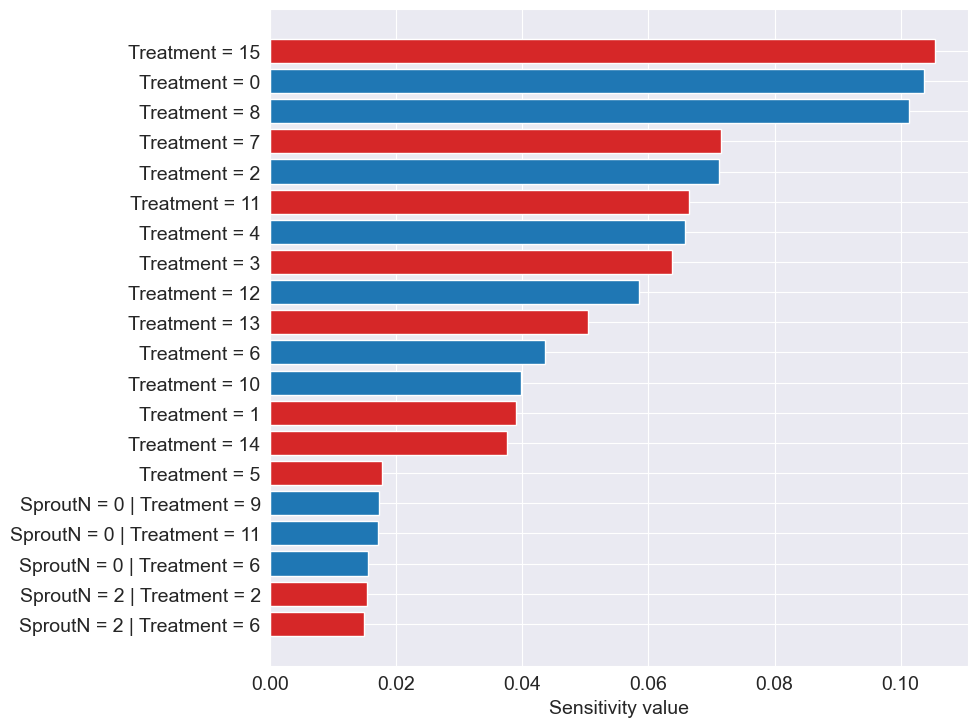

In [55]:
plt.figure()
yodo.plot(pgmpy_bn_bmrk, probability={'pH': 0}, nbars=20)

<Figure size 640x480 with 0 Axes>

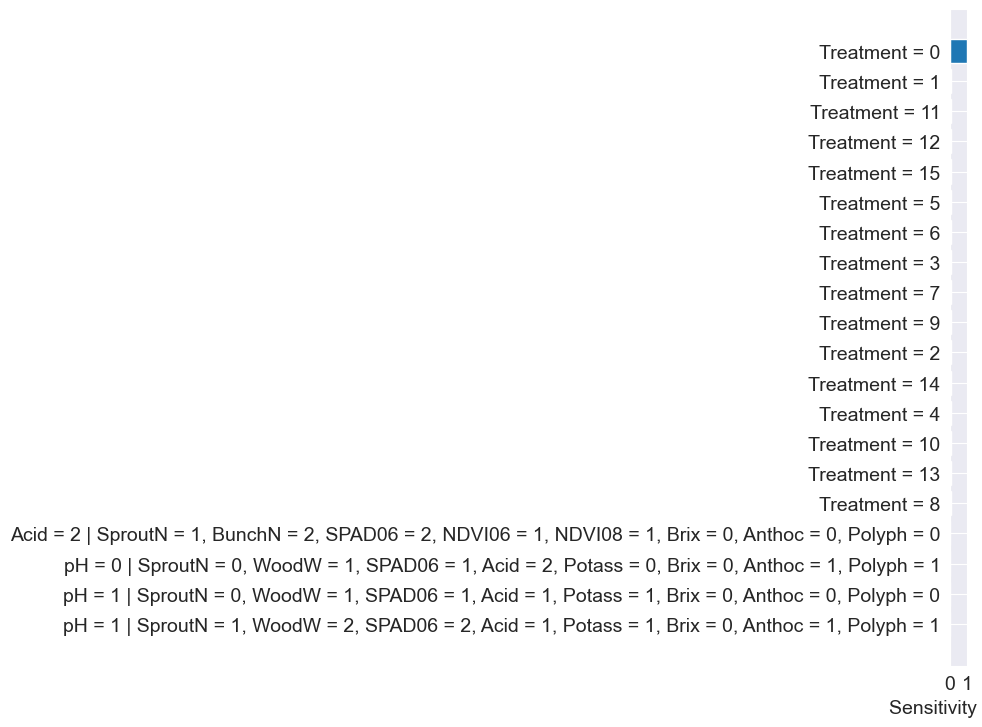

In [56]:
plt.figure()
yodo.plot(pgmpy_bn_bmrk, probability={'Treatment': 0}, nbars=20)

<Figure size 640x480 with 0 Axes>

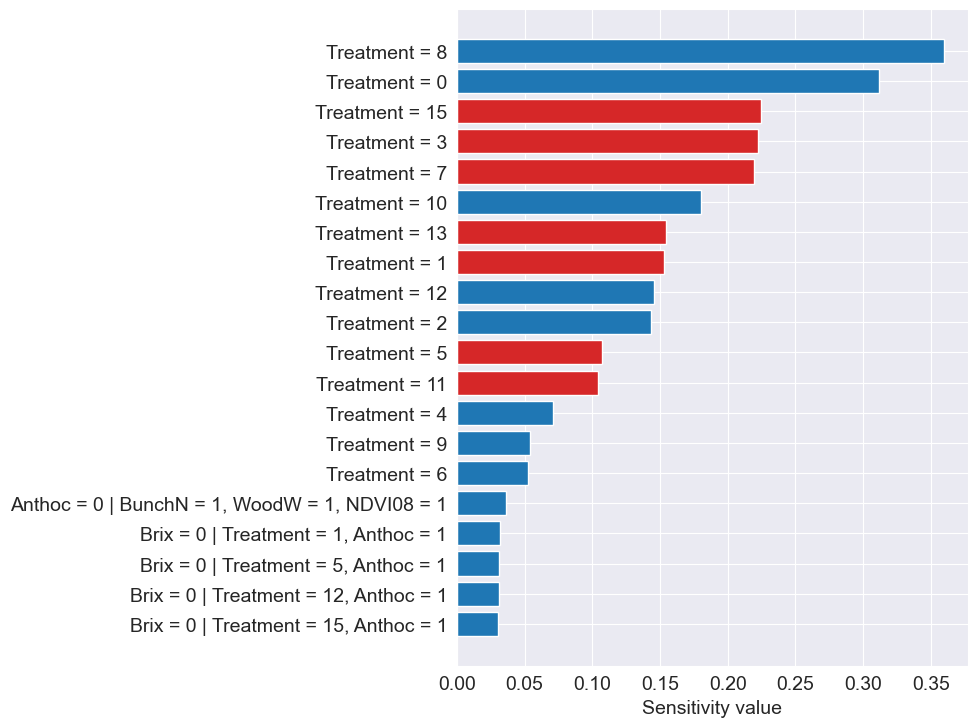

In [57]:
plt.figure()
yodo.plot(pgmpy_bn_bmrk, probability={'Brix': 0}, nbars=20)

In [58]:
nfeat = len(variables)

In [59]:
data

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,T6a,0.319352,-0.014638,0.690797,1.230259,0.202708,0.190496,0.273637,0.206928,-0.400711,0.151206,0.010867,0.136906,0.262685,0.066611
1,T1b,-0.467937,-0.356982,-0.261610,-0.505227,-0.030330,-0.160601,-0.189846,-0.214033,-0.016202,-0.050890,0.036074,0.024552,0.139368,0.249374
2,T3b,-0.041105,0.487735,1.354279,0.921248,0.120138,0.032949,0.112869,-0.092149,-0.142178,-0.061097,-0.090681,0.009475,-1.259641,-0.736169
3,T3b,-0.045981,0.283028,-0.528793,0.009379,0.018713,0.005606,-0.009545,0.156430,0.194600,-0.016099,0.110614,-0.003483,0.031440,0.266491
4,T3a,-0.143411,0.384641,0.202781,0.004403,-0.097482,0.097795,-0.016170,-0.086327,0.024270,-0.241405,-0.101967,-0.043688,-0.336990,-0.383633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,T8b,0.053395,-1.208246,-1.543112,-0.275032,-0.008297,0.130915,0.104711,-0.117720,-0.210763,0.113486,0.141659,0.047907,0.588953,0.034314
4996,T5b,-0.017949,0.557031,0.704254,0.219637,-0.037787,0.030786,0.045621,0.187205,0.116374,-0.323812,-0.061319,-0.030932,-0.499070,-0.134888
4997,T8a,0.054611,-0.117566,-0.280384,-0.379443,-0.014572,-0.062367,-0.071999,-0.026967,-0.065049,0.300600,-0.071896,0.039318,-0.125485,-0.255957
4998,T3b,-0.158751,-0.328153,-0.064735,-0.072703,0.011050,0.202459,-0.041926,0.006261,0.020728,0.116998,0.032961,-0.010355,0.318808,-0.089161


In [51]:
pipeline = OrdinalEncoder(categories=[["LOW", "AVG", "HIGH"]]*len(variables), dtype=np.int8,).fit_transform(data)
data_enc = pd.DataFrame(data_enc_arr, columns=variables)

In [61]:
bnres = construct_by_kmeans(data_enc, categoricals=variables,scoring=("K2", BicScore),
                            custom_mapper={"Treatment": {k: treatment_inv_map_src[k] for k in range(treatment_inv_map_src.shape[0])}},
                            max_cat=3)

In [63]:
treatment_inv_map_src

array(['T1a', 'T1b', 'T2a', 'T2b', 'T3a', 'T3b', 'T4a', 'T4b', 'T5a',
       'T5b', 'T6a', 'T6b', 'T7a', 'T7b', 'T8a', 'T8b'], dtype=object)

In [62]:
bnres["disc_data"]

,Treatment10,Treatment1,Treatment5,Treatment4,Treatment8,Treatment7,Treatment3,Treatment11,Treatment0,Treatment9,...,Brix2,pH2,pH1,pH0,Anthoc2,Anthoc1,Anthoc0,Polyph1,Polyph2,Polyph0
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4996,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4998,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [64]:
st_name_map = lambda x: x[:-1]+"_Low" if x[len(x)-1] == '0' else x[:-1]+"_Mid" if x[len(x)-1] == '1' else x[:-1]+"_High"
treatment_name_map = lambda x: x[:9]+treatment_inv_map_src[int(x[9:])]

states_name_map = lambda x: treatment_name_map(x) if "Treatment" in x else st_name_map(x)

In [65]:
bnres["disc_data"].rename(columns={e: states_name_map(e) for e in bnres["disc_data"].columns}, inplace=True)

In [66]:
bnres_giebn = DiscreteBNGI(imagespath)

blacklist = [(x, y) for x, y in product(bnres["disc_data"].columns, bnres["disc_data"].columns) if x.split("_")[0] == y.split("_")[0]]

bnres_giebn.add_nodes({"types": {e: "disc" for e in bnres["disc_data"].columns}})
bnres_giebn.add_edges(bnres["disc_data"], scoring_function=("K2", BicScore), params={'bl_add':blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [67]:
bnres_giebn.fit_parameters(data=bnres["disc_data"])

In [68]:
bnres_giebn.distributions

{'Acid_Mid': {'cprob': [0.5482, 0.4518], 'vals': ['0', '1']},
 'Potass_Mid': {'cprob': [0.5434, 0.4566], 'vals': ['0', '1']},
 'pH_Mid': {'cprob': {"['0']": [0.7183509668004378, 0.2816490331995622],
   "['1']": [0.3293492695883134, 0.6706507304116865]},
  'vals': ['0', '1']},
 'SPAD06_Mid': {'cprob': {"['0']": [0.5875414670106893, 0.41245853298931073],
   "['1']": [0.4564932225623087, 0.5435067774376913]},
  'vals': ['0', '1']},
 'SPAD08_Mid': {'cprob': {"['0', '0']": [0.6919698870765371,
    0.308030112923463],
   "['0', '1']": [0.6120689655172413, 0.3879310344827586],
   "['1', '0']": [0.4119749776586238, 0.5880250223413762],
   "['1', '1']": [0.3901850362027353, 0.6098149637972646]},
  'vals': ['0', '1']},
 'pH_High': {'cprob': {"['0', '0']": [0.62799740764744, 0.37200259235255995],
   "['0', '1']": [0.8018264840182648, 0.19817351598173513],
   "['1', '0']": [0.6969949916527546, 0.3030050083472455],
   "['1', '1']": [0.8608247422680413, 0.13917525773195877]},
  'vals': ['0', '1']},


In [69]:
n_states_map_giebn = {e: 2 for e in bnres["disc_data"].columns}

In [70]:
bnres_giebn_cpds = collect_all_cpds(bnres_giebn.get_info(), bnres_giebn.distributions, n_states_map_giebn)

In [72]:
bnres_giebn_cpds

[<TabularCPD representing P(Acid_Mid:2) at 0x23dfc8212a0>,
 <TabularCPD representing P(Potass_Mid:2) at 0x23d83817b80>,
 <TabularCPD representing P(pH_Mid:2 | Acid_Mid:2) at 0x23dfc821b40>,
 <TabularCPD representing P(SPAD06_Mid:2 | pH_Mid:2) at 0x23dfc822530>,
 <TabularCPD representing P(SPAD08_Mid:2 | SPAD06_Mid:2, pH_Mid:2) at 0x23dfc822920>,
 <TabularCPD representing P(pH_High:2 | SPAD06_Mid:2, Acid_Mid:2) at 0x23dfc8213f0>,
 <TabularCPD representing P(WoodW_Mid:2 | SPAD06_Mid:2, SPAD08_Mid:2) at 0x23dfc823550>,
 <TabularCPD representing P(NDVI06_Mid:2 | SPAD06_Mid:2, SPAD08_Mid:2) at 0x23dfc823dc0>,
 <TabularCPD representing P(NDVI08_Mid:2 | WoodW_Mid:2, SPAD08_Mid:2) at 0x23dfc821630>,
 <TabularCPD representing P(SproutN_Mid:2 | WoodW_Mid:2) at 0x23dfc8223b0>,
 <TabularCPD representing P(SPAD06_High:2 | WoodW_Mid:2, SPAD08_Mid:2, pH_High:2, pH_Mid:2) at 0x23dfc823730>,
 <TabularCPD representing P(WoodW_Low:2 | SPAD06_High:2, SPAD06_Mid:2, SPAD08_Mid:2) at 0x23dfc820f10>,
 <Tabula

In [73]:
pgmpy_giebn = BayesianNetwork()
pgmpy_giebn.add_nodes_from(bnres["disc_data"].columns)
pgmpy_giebn.add_edges_from([list(e) for e in bnres_giebn.edges])
for e in bnres_giebn_cpds:
    pgmpy_giebn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

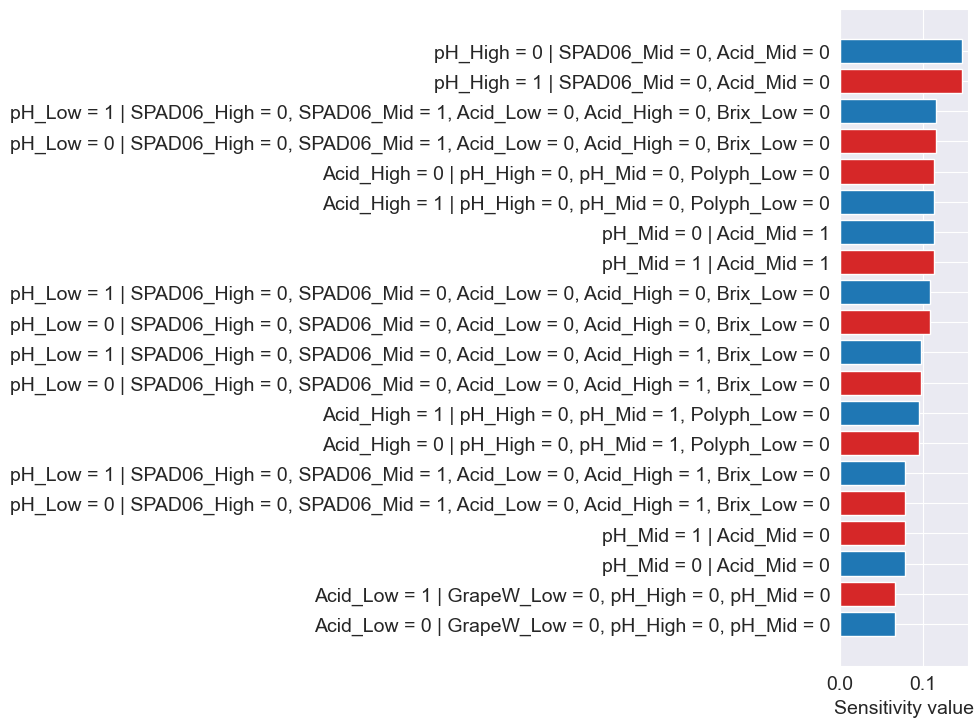

In [75]:
plt.figure()
yodo.plot(pgmpy_giebn, probability={'pH_Low': 1}, nbars=20)

<Figure size 640x480 with 0 Axes>

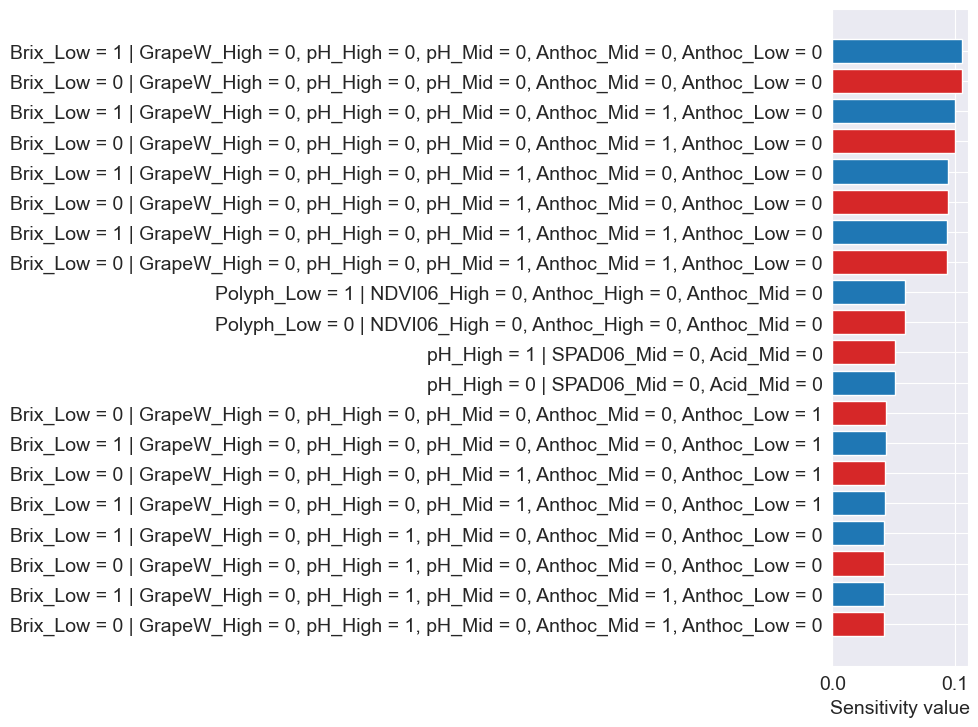

In [76]:
plt.figure()
yodo.plot(pgmpy_giebn, probability={'Brix_Low': 1}, nbars=20)